In [10]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler

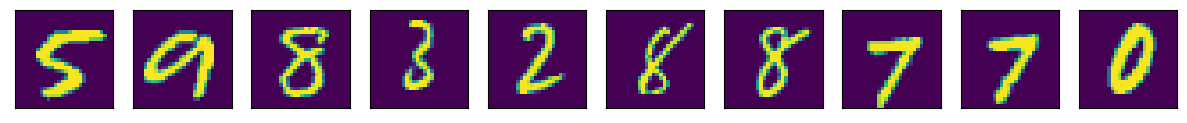

In [8]:
# Load the MNIST data set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to [0., 1.]
x_train = x_train / 255.
x_test = x_test / 255.

# Take a look at the dataset
n_samples = 10
idx = random.sample(range(x_train.shape[0]), n_samples)
plt.figure(figsize=(15,4))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(x_train[idx[i]].squeeze());
    plt.xticks([], [])
    plt.yticks([], [])

In [20]:
x_train.shape

(60000, 28, 28)

In [15]:
# This is the dimension of the latent space (encoding space)
latent_dim = 2

# Images are 28 by 28
img_shape = (x_train.shape[1], x_train.shape[2])

encoder = Sequential([
    Flatten(input_shape=img_shape),
    Dense(192, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(32, activation='sigmoid'),
    Dense(latent_dim, name='encoder_output')
])

decoder = Sequential([
    Dense(64, activation='sigmoid', input_shape=(latent_dim,)),
    Dense(128, activation='sigmoid'),
    Dense(img_shape[0] * img_shape[1], activation='sigmoid'),
    Reshape(img_shape)
])

In [16]:
class TestEncoder(tf.keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        super(TestEncoder, self).__init__()
        self.x_test = x_test
        self.y_test = y_test
        self.current_epoch = 0

    def on_epoch_begin(self, epoch, logs={}):
        self.current_epoch = self.current_epoch + 1
        encoder_model = Model(inputs=self.model.input,
                              outputs=self.model.get_layer('encoder_output').output)
        encoder_output = encoder_model(self.x_test)
        plt.subplot(4, 3, self.current_epoch)
        plt.scatter(encoder_output[:, 0],
                    encoder_output[:, 1], s=20, alpha=0.8,
                    cmap='Set1', c=self.y_test[0:x_test.shape[0]])
        plt.xlim(-9, 9)
        plt.ylim(-9, 9)
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')

autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

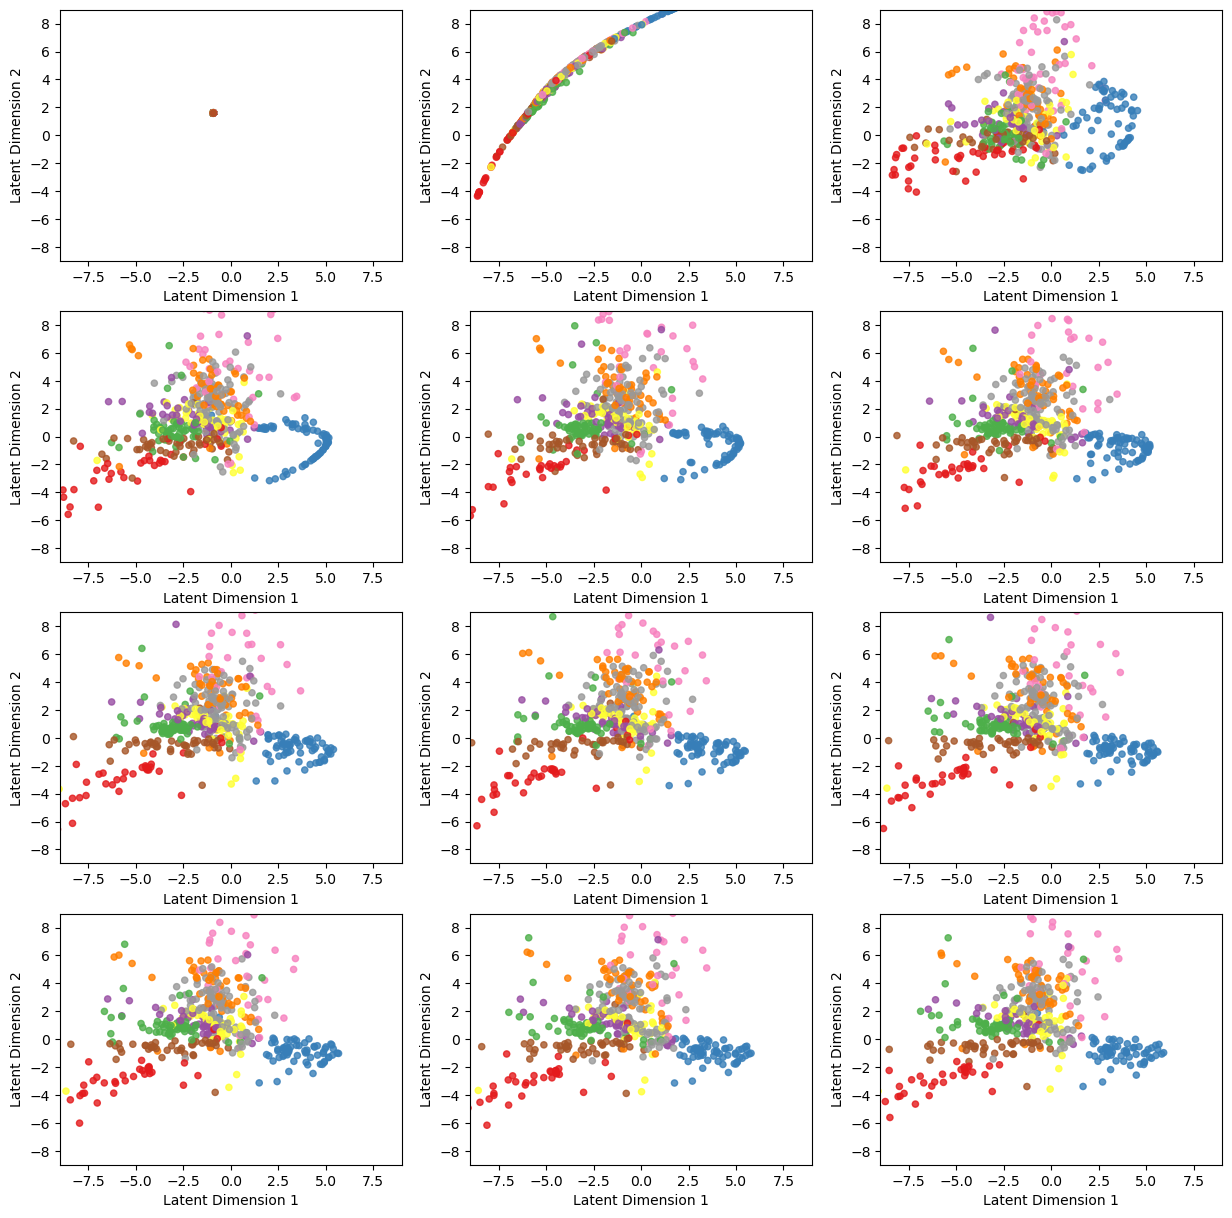

In [17]:
plt.figure(figsize=(15,15))
model_history = autoencoder.fit(x_train, x_train, epochs=12, batch_size=32, verbose=0,
                                callbacks=[TestEncoder(x_test[0:500], y_test[0:500])])

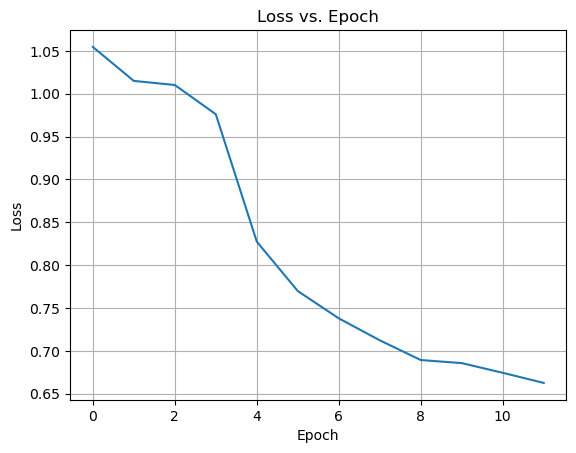

In [14]:
plt.plot(model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

NameError: name 'get_ave_values' is not defined

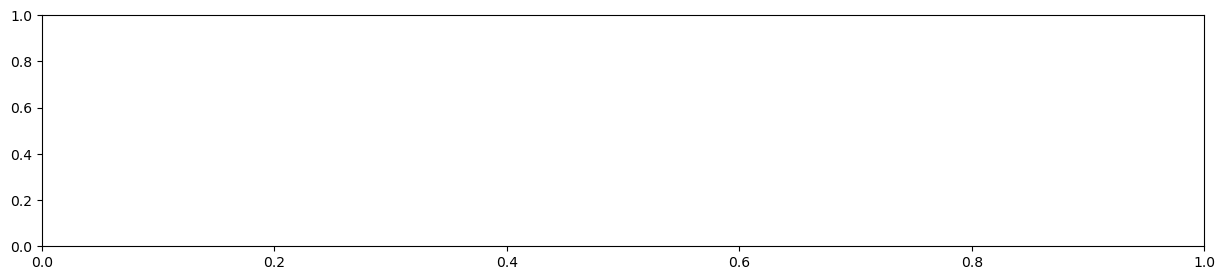

In [5]:
import pywt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()
 
def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
 
def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()
 
dataset = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"
df_nino = pd.read_table(dataset)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()
 
scales = np.arange(1, 128)
plot_signal_plus_average(time, signal)
plot_fft_plus_power(time, signal)
plot_wavelet(time, signal, scales)